In [53]:
# Basic
import numpy as np
import pandas as pd

# Load market data
import gsampler as gs

# Visualization
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

##### Load market data

In [54]:
def get_dataframe(symbol, colo, date):
    '''
    Obtaining a dataframe directly from gsampler:
    The dataframe contains:
        ask_book_price, ask_book_size from level 1 to level 5
        bid_book_price, bid_book_size from level 1 to level 5
        trade_price
        trade_volume
        trade_side
    '''
    dates = [date]
    features = []
    for i in range(5):
        features.append(gs.FeatureAskPrice(symbol = symbol, level = i))
        features.append(gs.FeatureAskQty(symbol = symbol, level = i))
    for i in range(5):
        features.append(gs.FeatureBidPrice(symbol = symbol, level = i))
        features.append(gs.FeatureBidQty(symbol = symbol, level = i))
    features.append(gs.FeatureTradePrice(symbol = symbol))
    features.append(gs.FeatureTradeSize(symbol = symbol))
    features.append(gs.FeatureTradeSide(symbol = symbol))
    features.append(gs.FeatureTickerIdCast())
    sampler = gs.SamplerRunner(features = features, dates = dates, colo = colo, cb_version = 'v2')
    sampler.run()
    df = sampler.load_data_df()
    df = df.between_time(start_time='09:02:00', end_time='15:33:00')
    df = df.fillna(0.)
    df.columns = ['ask_prc_0', 'ask_size_0', 
                  'ask_prc_1', 'ask_size_1', 
                  'ask_prc_2', 'ask_size_2',
                  'ask_prc_3', 'ask_size_3',
                  'ask_prc_4', 'ask_size_4', 
                  'bid_prc_0', 'bid_size_0', 
                  'bid_prc_1', 'bid_size_1', 
                  'bid_prc_2', 'bid_size_2',
                  'bid_prc_3', 'bid_size_3',
                  'bid_prc_4', 'bid_size_4',
                  'trad_price', 'trade_volume', 'trade_side', 
                  'a', 'b', 'time']
    df.drop('a', axis=1, inplace=True)
    df.drop('b', axis=1, inplace=True) 
    return df

DEBUG(PY: /ginkgo/Json.py:128:save) Writing file: /cache/zebo/2ca0b4d61a0b9c9b2dbf154b41f4049c7e5bc027/6261ce1f789171009bcb402620c7e21ed82802f0.json
DEBUG(PY: /ginkgo/Json.py:128:save) Writing file: /cache/zebo/2ca0b4d61a0b9c9b2dbf154b41f4049c7e5bc027/6261ce1f789171009bcb402620c7e21ed82802f0.json
*** All 1 day(s) have been sampled, clear_cache to resample OR add more days  
reading date=20171129 started


,ask_prc_0,ask_size_0,ask_prc_1,ask_size_1,ask_prc_2,ask_size_2,ask_prc_3,ask_size_3,ask_prc_4,ask_size_4,...,bid_prc_2,bid_size_2,bid_prc_3,bid_size_3,bid_prc_4,bid_size_4,trad_price,trade_volume,trade_side,time
time,,,,,,,,,,,,,,,,,,,,,
2017-11-29 09:02:00.016377,1084.2,30.0,1084.3,275.0,1084.4,99.0,1084.5,80.0,1084.6,96.0,...,1083.9,160.0,1083.8,178.0,1083.7,85.0,0.0,0.0,0.0,3.252002e+10
2017-11-29 09:02:00.018001,1084.2,30.0,1084.3,275.0,1084.4,99.0,1084.5,80.0,1084.6,96.0,...,1083.9,160.0,1083.8,178.0,1083.7,85.0,0.0,0.0,0.0,3.252002e+10


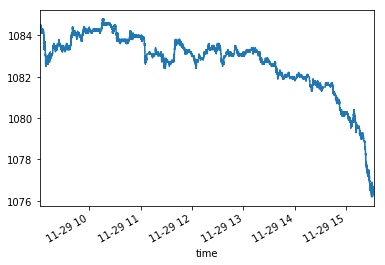

In [55]:
df = get_dataframe('KRW_G0.KRX', 'KRX', '20171129')
display(df[:2])
df.ask_prc_0.plot()

##### Convert the market dataframe into trainning features
1. Here we only consider booksize changes
2. We only considering 10 ms time interval changes

In [56]:
from keras.utils import np_utils
def snapShotConversion(prc, size, array_size = 160):
    '''
    Convert 5 levels of price, size into one hot notation
    '''
    return np.dot(size, np_utils.to_categorical(prc, num_classes=array_size))
def toImage(prc_feat, size_feat, array_size = 160):
    '''
    Convert price, size information into image notation
    '''
    return np.array([snapShotConversion(prc_feat[i], size_feat[i], array_size=array_size) for i in range(len(size_feat))])

In [57]:
## Convert dataframe in to intervaled book size info
MIN_PRICE = 1075
DELTA = 0.01
ARRAY_SIZE = 160 
def getIntervalBookInfo(df, start_time, end_time, time_interval='200000U'):
    df = df.drop(['trad_price', 'trade_volume', 'trade_side'], axis=1)
    
    # We create a common series of timestamps
    common_tseries = pd.DataFrame(pd.date_range("2017-11-29 {0}".format(start_time), 
                                                "2017-11-29 {0}".format(end_time), freq = time_interval))
    common_tseries = common_tseries.set_index(common_tseries.columns.values[0])
    common_index = common_tseries.index
    
    df = df.groupby(df.index).first()                                   # Remove duplicate indices
    
    uidx = df.index.union(common_index)                                 # We need first reindex the data on a union of indices
    df = df.reindex(uidx)
    df = df.ffill()                                       # Using forward fill to fill in the missing data
    df = df.reindex(common_index)                                       # using ghe common timestamps as index
    return df

,ask_prc_0,ask_size_0,ask_prc_1,ask_size_1,ask_prc_2,ask_size_2,ask_prc_3,ask_size_3,ask_prc_4,ask_size_4,...,bid_size_0,bid_prc_1,bid_size_1,bid_prc_2,bid_size_2,bid_prc_3,bid_size_3,bid_prc_4,bid_size_4,time
0,,,,,,,,,,,,,,,,,,,,,
2017-11-29 09:35:00.000,1083.4,52.0,1083.5,588.0,1083.6,537.0,1083.7,284.0,1083.8,265.0,...,246.0,1083.2,274.0,1083.1,439.0,1083.0,286.0,1082.9,192.0,3.449952e+10
2017-11-29 09:35:00.200,1083.4,52.0,1083.5,588.0,1083.6,537.0,1083.7,284.0,1083.8,265.0,...,246.0,1083.2,274.0,1083.1,439.0,1083.0,286.0,1082.9,192.0,3.449952e+10
2017-11-29 09:35:00.400,1083.4,52.0,1083.5,588.0,1083.6,537.0,1083.7,284.0,1083.8,265.0,...,246.0,1083.2,274.0,1083.1,439.0,1083.0,286.0,1082.9,192.0,3.449952e+10
2017-11-29 09:35:00.600,1083.4,52.0,1083.5,588.0,1083.6,537.0,1083.7,284.0,1083.8,265.0,...,246.0,1083.2,274.0,1083.1,439.0,1083.0,286.0,1082.9,192.0,3.449952e+10
2017-11-29 09:35:00.800,1083.4,52.0,1083.5,588.0,1083.6,537.0,1083.7,284.0,1083.8,265.0,...,246.0,1083.2,274.0,1083.1,439.0,1083.0,286.0,1082.9,192.0,3.449952e+10


103501


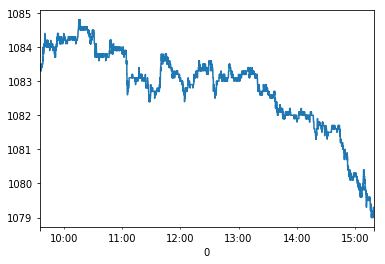

In [58]:
df_interval = getIntervalBookInfo(df, "09:35", "15:20")
display(df_interval[:5])
print len(df_interval)
df_interval.ask_prc_0.plot()

In [59]:
## get book features
def getAskBidFeatures(df, min_price = 1075, tick_size = 0.1, array_size = 160, delta = 0.01):
    
    ## Ask levels
    ask_prc_feat = df[['ask_prc_{0}'.format(str(i)) for i in range(5)]].as_matrix()
    ask_size_feat = df[['ask_size_{0}'.format(str(i)) for i in range(5)]].as_matrix()
    assert(ask_prc_feat.max() < min_price + tick_size*array_size)
    ask_prc_feat = (ask_prc_feat - min_price + delta)/tick_size
    ask_prc_feat = ask_prc_feat.astype(np.int16)
    ask_prc_feat[ask_prc_feat < 0] = 0
    ask_size_feat = np.log(ask_size_feat + 1.)
    ask_book = toImage(ask_prc_feat, ask_size_feat, array_size=array_size)
    
    ## Bid levels
    bid_prc_feat = df[['bid_prc_{0}'.format(str(i)) for i in range(5)]].as_matrix()
    bid_size_feat = df[['bid_size_{0}'.format(str(i)) for i in range(5)]].as_matrix()
    assert(bid_prc_feat.max() < min_price + tick_size*array_size)
    bid_prc_feat = (bid_prc_feat - min_price + delta)/tick_size
    bid_prc_feat = bid_prc_feat.astype(np.int16)
    bid_prc_feat[bid_prc_feat < 0] = 0
    bid_size_feat = np.log(bid_size_feat + 1.)
    bid_book = toImage(bid_prc_feat, bid_size_feat, array_size=array_size)
    
    return ask_book, bid_book

In [60]:
ask_book_feat, bid_book_feat = getAskBidFeatures(df_interval)

##### Visualize the book features:
- ASK

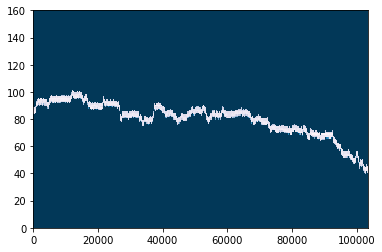

In [61]:
plt.pcolormesh(ask_book_feat.transpose(), cmap='PuBu_r')

- BID

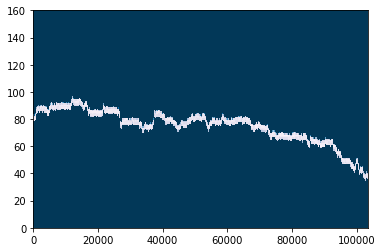

In [62]:
plt.pcolormesh(bid_book_feat.transpose(), cmap='PuBu_r')

- Target (MID PRICE)

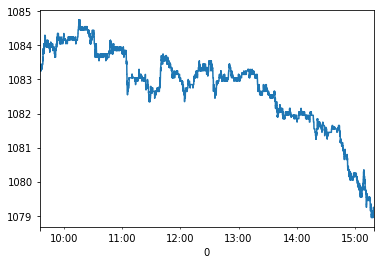

In [63]:
df_interval['target'] = (df_interval.ask_prc_0 + df_interval.bid_prc_0)/2.
df_interval.target.plot()
raw_y = np.array(df_interval.target.tolist())

In [64]:
print ask_book_feat.shape, ask_book_feat.max()
print bid_book_feat.shape, bid_book_feat.max()
print raw_y.shape

(103501, 160) 6.74051935961
(103501, 160) 6.75460409949
(103501,)


###### Using Lookback = 60 (: 12s)

In [65]:
LOOK_BACK = 60
%time raw_x_ask = np.array([ask_book_feat[i: i+LOOK_BACK] for i in range(len(ask_book_feat) - 300)])
%time raw_x_bid = np.array([bid_book_feat[i: i+LOOK_BACK] for i in range(len(bid_book_feat) - 300)])
print raw_x_ask.shape
print raw_x_bid.shape

CPU times: user 884 ms, sys: 18.8 s, total: 19.7 s
Wall time: 19.4 s
CPU times: user 777 ms, sys: 48.6 s, total: 49.4 s
Wall time: 48.5 s
(103201, 60, 160)
(103201, 60, 160)


In [66]:
## reshape
a, b, c = raw_x_ask.shape
raw_x_ask = raw_x_ask.reshape(a, b, c, 1)
raw_x_bid = raw_x_bid.reshape(a, b, c, 1)
print raw_x_ask.shape
print raw_x_bid.shape

(103201, 60, 160, 1)
(103201, 60, 160, 1)


###### TRYing Horizon = 10 time stamp

In [67]:
HORIZON = 3
%time raw_y = raw_y[LOOK_BACK + HORIZON: LOOK_BACK + HORIZON + len(ask_book_feat) - 100]
print raw_y.shape

CPU times: user 9 µs, sys: 12 µs, total: 21 µs
Wall time: 33.1 µs
(103401,)


In [68]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, Activation, concatenate, GRU, Embedding, Flatten
from keras.layers import Flatten, Conv2D, MaxPooling2D, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [69]:
# Splitting train and test sets
N_train = int(len(raw_y)*0.8)
N_test = len(raw_y) - N_train
train_ask = raw_x_ask[: N_train]
test_ask = raw_x_ask[N_train:]
train_bid = raw_x_bid[: N_train]
test_bid = raw_x_bid[N_train:]
train_y = raw_y[: N_train]
test_y = raw_y[N_train:]

1084.75 1081.75
[ 1083.25  1083.25  1083.25  1083.25  1083.25  1083.25  1083.25  1083.25
  1083.25  1083.25  1083.25  1083.25  1083.25  1083.25  1083.25  1083.25
  1083.25  1083.25  1083.25  1083.35]


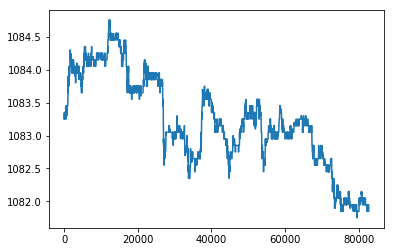

In [70]:
print train_y.max(), train_y.min()
target_scaler = MinMaxScaler(feature_range=(-1, 1))
print train_y[:20]
plt.plot(train_y)

In [71]:
## Constructing Model
#Inputs
ask_book = Input(shape=train_ask.shape[1:], name="ask_book")
bid_book = Input(shape=train_bid.shape[1:], name="bid_book")

# 2D convs
ask_conv = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(ask_book)
ask_conv = MaxPooling2D(pool_size = (2, 2)) (ask_conv)
ask_conv = Dropout(0.5) (ask_conv)
ask_conv = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(ask_conv)
ask_conv = MaxPooling2D(pool_size = (2, 2)) (ask_conv)
ask_conv = Dropout(0.75) (ask_conv)

bid_conv = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(bid_book)
bid_conv = MaxPooling2D(pool_size = (2, 2)) (bid_conv)
bid_conv = Dropout(0.5) (bid_conv)
bid_conv = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(bid_conv)
bid_conv = MaxPooling2D(pool_size = (2, 2)) (bid_conv)
bid_conv = Dropout(0.75) (bid_conv)

main_layer = concatenate([
    Flatten() (ask_conv),
    Flatten() (bid_conv),
])
main_layer = Dropout(0.8) (Dense(32) (main_layer))
output = Dense(1, activation="linear") (main_layer)
model = Model([ask_book, bid_book], output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
ask_book (InputLayer)            (None, 60, 160, 1)    0                                            
____________________________________________________________________________________________________
bid_book (InputLayer)            (None, 60, 160, 1)    0                                            
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 60, 160, 4)    104                                          
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 60, 160, 4)    104                                          
___________________________________________________________________________________________

In [72]:
# Split train into tr and cv
N_tr = int(len(train_y)*0.8)
tr_ask = train_ask[:N_tr]
cv_ask = train_ask[N_tr:]
tr_bid = train_bid[:N_tr]
cv_bid = train_bid[N_tr:]
tr_y = train_y[:N_tr]
cv_y = train_y[N_tr:]

In [75]:
#model
optimizer = Adam(0.05)
model.compile(loss="mse", optimizer=optimizer)

In [76]:
#FITTING THE MODEL
BATCH_SIZE  =  256
epochs = 10
model.fit([tr_ask, tr_bid], tr_y, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=([cv_ask, cv_bid], cv_y)
          , verbose=1)

Train on 66176 samples, validate on 16544 samples
Epoch 1/10
66176/66176 [==============================] - 37s - loss: 147182.9732 - val_loss: 44516.0849
Epoch 2/10
66176/66176 [==============================] - 36s - loss: 131968.4730 - val_loss: 24719.6331
Epoch 3/10
66176/66176 [==============================] - 34s - loss: 134732.4760 - val_loss: 10895.9426
Epoch 4/10
66176/66176 [==============================] - 35s - loss: 127905.1461 - val_loss: 563.9938
Epoch 5/10
66176/66176 [==============================] - 36s - loss: 126133.4244 - val_loss: 3661.9168
Epoch 6/10
66176/66176 [==============================] - 33s - loss: 124848.4759 - val_loss: 36779.8700
Epoch 7/10
66176/66176 [==============================] - 34s - loss: 120531.5712 - val_loss: 3274.5491
Epoch 8/10
66176/66176 [==============================] - 35s - loss: 118828.4968 - val_loss: 5800.8859
Epoch 9/10
66176/66176 [==============================] - 36s - loss: 116333.0534 - val_loss: 3442.5858
Epoch 10/10

In [77]:
#CREATE PREDICTIONS
preds = model.predict([test_ask, test_bid], batch_size=BATCH_SIZE)

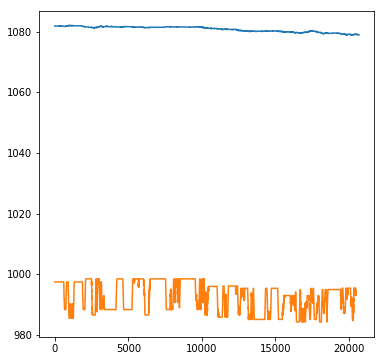

In [78]:
# show results
fig, ax = plt.subplots(1,1, figsize = (6, 6))
ax.plot(test_y)
ax.plot(preds)